<a href="https://colab.research.google.com/github/YairYarden/DeepCascadingAMC/blob/feature%2Fcascade_AMC_SEN/Ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Chose Device

In [ ]:
# check if CUDA is available
import torch
is_gpu_available = torch.cuda.is_available()

if not is_gpu_available:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

CUDA is available!  Training on GPU ...


# Load Python Files

In [ ]:
# Load files 
from google.colab import files

# Dataset Classes
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/encoder.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/dataset.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/dataset_builder.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/rml_2016.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/RML2016_SNR_groups_DataLoader.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/data/snr_encoder.py /content

# Utils Classes
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/utils/plot.py /content

# Training Classes
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/training/accuracy.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/training/confusion.py /content
!cp /content/drive/MyDrive/Deep_learning_05107255/project/code/AMC_classes/training/baseModel.py /content



# Import Functions & Classes

In [ ]:
# Plotting Includes
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# External Includes
import numpy as np
from pprint import pprint

from torch.autograd import Variable
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

# Internal Includes
# Data
from dataset import Dataset
from encoder import Encoder
from rml_2016 import load_RML201610B_dataset
from RML2016_SNR_groups_DataLoader import load_RML201610B_dividedBySNR
from snr_encoder import SNREncoder

# Utils
from plot import plot_acc_vs_snr, plot_confusion, plot_convergence, plot_IQ

# Training
from accuracy import compute_accuracy, compute_accuracy_on_cross_sections
from accuracy import compute_cascaded_sen_amc_accuracy
from confusion import compute_confusion
from baseModel import Model

ImportError: ignored

# Load Dataset

## Load 

In [ ]:
# Load
import os
drive_path = '/content/drive/MyDrive/Deep_learning_05107255/project'
data_path = os.path.join(drive_path, 'RadioML2016_b/RML2016.10b.dat')
# FULL Dataset
dataset = load_RML201610B_dataset(path=data_path)

# Print
print(len(dataset))
pprint(dataset.get_examples_per_class())

1200000
{'8PSK': 120000,
 'AM-DSB': 120000,
 'BPSK': 120000,
 'CPFSK': 120000,
 'GFSK': 120000,
 'PAM4': 120000,
 'QAM16': 120000,
 'QAM64': 120000,
 'QPSK': 120000,
 'WBFM': 120000}


In [ ]:
# Dataset divided to 3 SNR Groups
datasetLow, dataMed, datasetHigh = load_RML201610B_dividedBySNR(path=data_path)

# Print
print('Num examples High SNR :', len(datasetHigh))
print('Num examples Medium SNR :', len(dataMed))
print('Num examples Low SNR :', len(datasetLow))
print('High SNR per class examples :')
pprint(datasetHigh.get_examples_per_class())

Num examples High SNR : 420000
Num examples Medium SNR : 420000
Num examples Low SNR : 360000
High SNR per class examples :
{'8PSK': 42000,
 'AM-DSB': 42000,
 'BPSK': 42000,
 'CPFSK': 42000,
 'GFSK': 42000,
 'PAM4': 42000,
 'QAM16': 42000,
 'QAM64': 42000,
 'QPSK': 42000,
 'WBFM': 42000}


## Split to Train - Val - Test

In [ ]:
# All together
train, test = dataset.split(frac=0.3, on=["Modulation", "SNR"])
train, val = train.split(frac=0.05, on=["Modulation", "SNR"])
# -----------------------------------------------------------------
# Splitted to SNR
# High
train_high_snr, test_high_snr = datasetHigh.split(frac=0.3, on=["Modulation", "SNR"])
train_high_snr, val_high_snr = train_high_snr.split(frac=0.05, on=["Modulation", "SNR"])
# medium
train_med_snr, test_med_snr = dataMed.split(frac=0.3, on=["Modulation", "SNR"])
train_med_snr, val_med_snr = train_med_snr.split(frac=0.05, on=["Modulation", "SNR"])
# low
train_low_snr, test_low_snr = datasetLow.split(frac=0.3, on=["Modulation", "SNR"])
train_low_snr, val_low_snr = train_low_snr.split(frac=0.05, on=["Modulation", "SNR"])

# -----------------------------------------------------------------
print("Training Examples")
print("=================")
pprint(train.get_examples_per_class())
print("=================")
print()
print("Validation Examples")
print("=================")
pprint(val.get_examples_per_class())
print("=================")
print()
print("Testing Examples")
print("=================")
pprint(test.get_examples_per_class())
print("=================")

Training Examples
{'8PSK': 79780,
 'AM-DSB': 79780,
 'BPSK': 79780,
 'CPFSK': 79780,
 'GFSK': 79780,
 'PAM4': 79780,
 'QAM16': 79780,
 'QAM64': 79780,
 'QPSK': 79780,
 'WBFM': 79780}

Validation Examples
{'8PSK': 4200,
 'AM-DSB': 4200,
 'BPSK': 4200,
 'CPFSK': 4200,
 'GFSK': 4200,
 'PAM4': 4200,
 'QAM16': 4200,
 'QAM64': 4200,
 'QPSK': 4200,
 'WBFM': 4200}

Testing Examples
{'8PSK': 36020,
 'AM-DSB': 36020,
 'BPSK': 36020,
 'CPFSK': 36020,
 'GFSK': 36020,
 'PAM4': 36020,
 'QAM16': 36020,
 'QAM64': 36020,
 'QPSK': 36020,
 'WBFM': 36020}


## SNR encoder

In [ ]:
snr_enc = SNREncoder(label_name="SNR")


## Labels encoder

In [ ]:
le = Encoder(["WBFM",
              "AM-DSB",
              "CPFSK",
              "GFSK",
              "BPSK",
              "QPSK",
              "8PSK",
              "PAM4",
              "QAM16",
              "QAM64"],
             label_name="Modulation")
print(le)

WBFM: 0
AM-DSB: 1
CPFSK: 2
GFSK: 3
BPSK: 4
QPSK: 5
8PSK: 6
PAM4: 7
QAM16: 8
QAM64: 9



## Plot Example

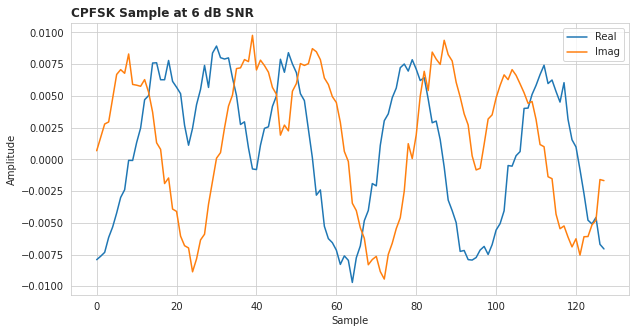

In [ ]:
fig_dir = None
# Plot a sample of the data
# You can choose a different sample by changing
idx = 10
snr = 6
modulation = "CPFSK"

mask = (dataset.df["SNR"] == snr) & (dataset.df["Modulation"] == modulation)
sample = dataset.as_numpy(mask=mask, le=le)[0][idx,0,:]
t = np.arange(sample.shape[1])

title = "{modulation} Sample at {snr:.0f} dB SNR".format(modulation=modulation, snr=snr)
fig = plot_IQ(iq=sample, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/{modulation}_{snr:.0f}dB_sample.pdf".format(fig_dir=fig_dir,
                                                                       modulation=modulation,
                                                                       snr=snr)
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

# Model

In [ ]:
class CNN1(Model):
    def __init__(self, input_samples: int, n_classes: int):
        super().__init__(input_samples=input_samples, n_classes=n_classes)
        # Batch x 1-channel x IQ x input_samples
        
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=256,
            kernel_size=(1, 7),
            padding=(0, 3),
            bias=False,
        )
        self.a1 = nn.ReLU()
        self.n1 = nn.BatchNorm2d(256)

        self.conv2 = nn.Conv2d(
            in_channels=256,
            out_channels=80,
            kernel_size=(1, 7),
            padding=(0, 3),
            bias=True,
        )
        self.a2 = nn.ReLU()
        self.n2 = nn.BatchNorm2d(80)

        self.conv3 = nn.Conv2d(
            in_channels=80,
            out_channels=30,
            kernel_size=(2, 7),
            padding=(0, 3),
            bias=True,
        )

        self.a3 = nn.ReLU()
        self.n3 = nn.BatchNorm2d(30)

        # Batch x Features
        self.dense1 = nn.Linear(30 * 1 * input_samples, 256)
        self.a4 = nn.ReLU()
        self.n4 = nn.BatchNorm1d(256)

        self.dense2 = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.a1(x)
        x = self.n1(x)

        x = self.conv2(x)
        x = self.a2(x)
        x = self.n2(x)

        x = self.conv3(x)
        x = self.a3(x)
        x = self.n3(x)

        # Flatten the input layer down to 1-d by using Tensor operations
        x = x.contiguous()
        x = x.view(x.size()[0], -1)

        x = self.dense1(x)
        x = self.a4(x)
        x = self.n4(x)

        x = self.dense2(x)

        return x

model = CNN1(input_samples=128, n_classes=10)
print(model)       

CNN1(
  (conv1): Conv2d(1, 256, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3), bias=False)
  (a1): ReLU()
  (n1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 80, kernel_size=(1, 7), stride=(1, 1), padding=(0, 3))
  (a2): ReLU()
  (n2): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(80, 30, kernel_size=(2, 7), stride=(1, 1), padding=(0, 3))
  (a3): ReLU()
  (n3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense1): Linear(in_features=3840, out_features=256, bias=True)
  (a4): ReLU()
  (n4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense2): Linear(in_features=256, out_features=10, bias=True)
)
----------------------
Trainable Parameters: 1165972
Fixed Parameters: 0
Total Parameters: 1165972
----------------------



# Training Functions

In [ ]:
class MyTrainingStrategy(object):

    def __init__(self, lr: float = 10e-4, n_epochs: int = 3, gpu: bool = True):
        self.lr = lr
        self.n_epochs = n_epochs
        self.gpu = gpu

    def __repr__(self):
        ret = self.__class__.__name__
        ret += "(lr={}, n_epochs={}, gpu={})".format(self.lr, self.n_epochs, self.gpu)
        return ret
        
    def __call__(
        self, model: nn.Module, training: Dataset, validation: Dataset, le: Encoder
    ):
        criterion = nn.CrossEntropyLoss()

        if self.gpu:
            model.cuda()
            criterion.cuda()

        optimizer = Adam(model.parameters(), lr=self.lr)

        train_data = DataLoader(
            training.as_torch(le=le), shuffle=True, batch_size=512
        )
        val_data = DataLoader(
            validation.as_torch(le=le), shuffle=True, batch_size=512
        )

        # Save two lists for plotting a convergence graph at the end
        ret_train_loss = list()
        ret_val_loss = list()
        
        for epoch in range(self.n_epochs):
            model, train_loss = self._train_one_epoch(model=model, data=train_data, loss_fn=criterion, optimizer=optimizer)

            print("On Epoch {} the training loss was {}".format(epoch, train_loss))
            ret_train_loss.append(train_loss)

            val_loss = self._validate_once(
                model=model, data=val_data, loss_fn=criterion
            )
            print("---- validation loss was {}".format(val_loss))
            ret_val_loss.append(val_loss)

        return model, ret_train_loss, ret_val_loss

    def _train_one_epoch(
        self, model: nn.Module, data: DataLoader, loss_fn: nn.CrossEntropyLoss, optimizer: Adam
    ) -> float:
        total_loss = 0.0
        # Switch the model mode so it remembers gradients, induces dropout, etc.
        model.train()

        for i, batch in enumerate(data):
            x, y = batch

            # Push data to GPU if necessary
            if self.gpu:
                x = Variable(x.cuda())
                y = Variable(y.cuda())
            else:
                x = Variable(x)
                y = Variable(y)

            # Forward pass of prediction
            outputs = model(x)

            # Zero out the parameter gradients, because they are cumulative,
            # compute loss, compute gradients (backward), update weights
            loss = loss_fn(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        mean_loss = total_loss / (i + 1.0)
        return model, mean_loss

    def _validate_once(
        self, model: nn.Module, data: DataLoader, loss_fn: nn.CrossEntropyLoss
    ) -> float:
        total_loss = 0.0
        # Switch the model back to test mode (so that batch norm/dropout doesn't
        # take effect)
        model.eval()
        for i, batch in enumerate(data):
            x, y = batch

            if self.gpu:
                x = x.cuda()
                y = y.cuda()

            outputs = model(x)
            loss = loss_fn(outputs, y)
            total_loss += loss.item()

        mean_loss = total_loss / (i + 1.0)
        return mean_loss

# ----------------------------------------------------------------- #
from datetime import datetime 
def save_model(model, dir_path, name):
  # create checkpints folder
  checkpoint_folder = os.path.join(dir_path, 'checkpoints')
  os.makedirs(checkpoint_folder, exist_ok=True)
  # save model
  curr_datetime = datetime.now().strftime("%y_%m_%d_%H:%M:%S")
  model_name = f'{curr_datetime}'.replace(':', '_')
  model_name = name + '_' + model_name
  
  ckpt_path = os.path.join(checkpoint_folder, f'{model_name}.ckpt')
  torch.save({
    'model_state_dict': model.state_dict(),
  }, ckpt_path)

  print(f'model saved to "{ckpt_path}"')

In [ ]:
gpu = is_gpu_available
trainer = MyTrainingStrategy(gpu=gpu)
print(trainer)

MyTrainingStrategy(lr=0.001, n_epochs=3, gpu=True)


# Train the network

## Train on all examples

In [ ]:
model_allSNR, train_loss_allSNR, val_loss_allSNR = trainer(model=model, training=train, validation=val, le=le)

On Epoch 0 the training loss was 0.9800630400699251
---- validation loss was 0.9515002362699394
On Epoch 1 the training loss was 0.9428590792276066
---- validation loss was 0.9544099856571979
On Epoch 2 the training loss was 0.9259567410231707
---- validation loss was 0.947456399360335


## Train By SNR groups

### High SNR (6 : 18[dB])

In [ ]:
model_highSNR, train_loss_highSNR, val_loss_highSNR = trainer(model=model, training=train_high_snr, validation=val_high_snr, le=le)



On Epoch 0 the training loss was 0.4346508245655905
---- validation loss was 0.3067838354357358
On Epoch 1 the training loss was 0.283116011146879
---- validation loss was 0.2800973309525128
On Epoch 2 the training loss was 0.24950376723384682
---- validation loss was 0.2442458667631807


### Medium SNR (-8 : 4 [dB])

In [ ]:
model_medSNR, train_loss_medSNR, val_loss_medSNR = trainer(model=model, training=train_med_snr, validation=val_med_snr, le=le)


On Epoch 0 the training loss was 0.7001809299865485
---- validation loss was 0.6281697462344992
On Epoch 1 the training loss was 0.6062524709509406
---- validation loss was 0.61386304888232
On Epoch 2 the training loss was 0.5726185834560639
---- validation loss was 0.590921845929376


### Low SNR (-20 : - 10 [dB])

In [ ]:
model_lowSNR, train_loss_lowSNR, val_loss_lowSNR = trainer(model=model, training=train_low_snr, validation=val_low_snr, le=le)


On Epoch 0 the training loss was 2.2136602666642933
---- validation loss was 2.2086414337158202
On Epoch 1 the training loss was 2.084619309657659
---- validation loss was 2.3752005004882815
On Epoch 2 the training loss was 2.069360450292245
---- validation loss was 2.1241593074798586


## Train SEN

In [ ]:
sen_model = CNN1(input_samples=128, n_classes=snr_enc.n_classes)
sen_model, sen_train_loss, sen_val_loss = trainer(model=sen_model, training=train, validation=val, le=snr_enc)

On Epoch 0 the training loss was 0.24195163230088523
---- validation loss was 0.22038345685206265
On Epoch 1 the training loss was 0.20000389449637695
---- validation loss was 0.2166745964303074
On Epoch 2 the training loss was 0.19256177008381403
---- validation loss was 0.1886318839458098


## Plot results 

### All SNR's

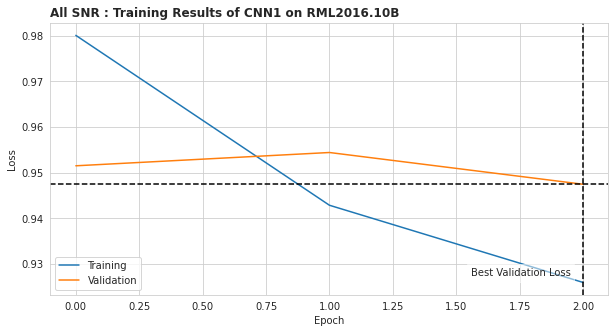

In [ ]:
title = "All SNR : Training Results of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_convergence(train_loss=train_loss_allSNR, val_loss=val_loss_allSNR, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/allSNR_training_loss.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### High SNR

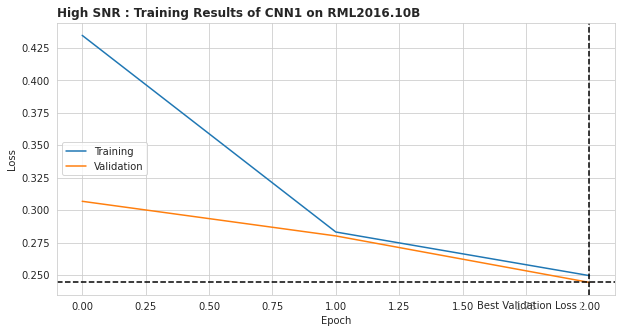

In [ ]:
title = "High SNR : Training Results of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_convergence(train_loss=train_loss_highSNR, val_loss=val_loss_highSNR, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/highSNR_training_loss.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### Medium SNR

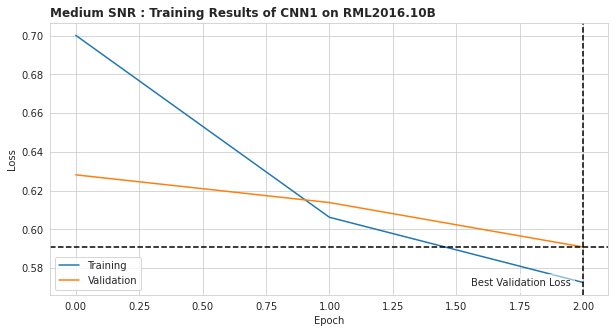

In [ ]:
title = "Medium SNR : Training Results of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_convergence(train_loss=train_loss_medSNR, val_loss=val_loss_medSNR, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/medSNR_training_loss.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### Low SNR

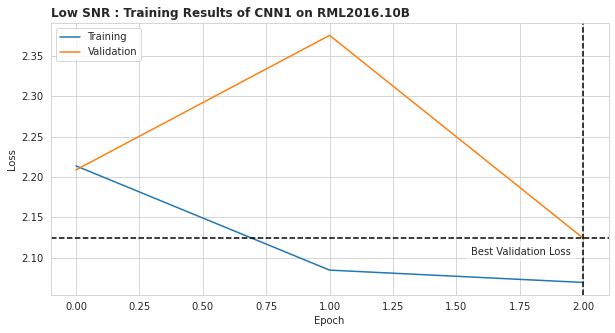

In [ ]:
title = "Low SNR : Training Results of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_convergence(train_loss=train_loss_lowSNR, val_loss=val_loss_lowSNR, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/lowSNR_training_loss.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### SEN

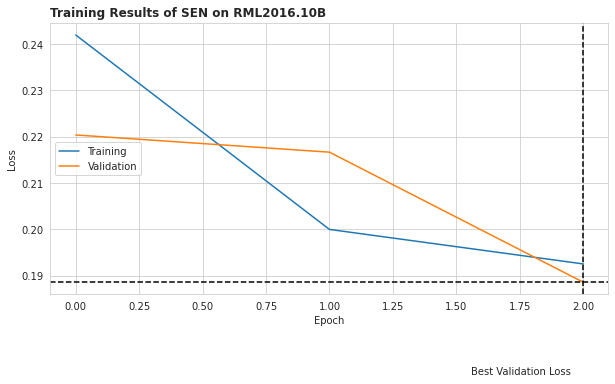

In [ ]:
title = "Training Results of {model_name} on {dataset_name}".format(model_name="SEN", dataset_name="RML2016.10B")
fig = plot_convergence(train_loss=sen_train_loss, val_loss=sen_val_loss, title=title)
plt.show()

# Save Model

In [ ]:
# all SNR
save_model(model_allSNR, drive_path, 'allSNR_CNN1_AMC_3_epochs')
# High SNR
save_model(model_highSNR, drive_path, 'highSNRSnr_CNN1_AMC_3_epochs')
# medium SNR
save_model(model_medSNR, drive_path, 'medSNR_CNN1_AMC_3_epochs')
# low SNR 
save_model(model_lowSNR, drive_path, 'lowSNR_CNN1_AMC_3_epochs')
# SEN model
save_model(sen_model, drive_path, 'SEN_CNN1_3_epochs')

model saved to "/content/drive/MyDrive/Deep_learning_05107255/project/checkpoints/allSNR_CNN1_AMC_3_epochs_22_07_24_18_28_13.ckpt"
model saved to "/content/drive/MyDrive/Deep_learning_05107255/project/checkpoints/highSNRSnr_CNN1_AMC_3_epochs_22_07_24_18_28_13.ckpt"
model saved to "/content/drive/MyDrive/Deep_learning_05107255/project/checkpoints/medSNR_CNN1_AMC_3_epochs_22_07_24_18_28_13.ckpt"
model saved to "/content/drive/MyDrive/Deep_learning_05107255/project/checkpoints/lowSNR_CNN1_AMC_3_epochs_22_07_24_18_28_13.ckpt"


# Load Pre-trained models

In [ ]:
# ALL SNR
# allSNR_ckpt_path = f'{drive_path}/checkpoints/allSNR_CNN1_AMC_3_epochs_22_07.ckpt'
# allSNR_checkpoint = torch.load(allSNR_ckpt_path)
# model_allSNR = CNN1(input_samples=128, n_classes=10)
# model_allSNR.load_state_dict(allSNR_checkpoint['model_state_dict'])

# HIGH SNR
highSNR_ckpt_path = f'{drive_path}/checkpoints/highSNR_CNN1_AMC_3_epochs_22_07.ckpt'
highSNR_checkpoint = torch.load(highSNR_ckpt_path)
model_highSNR = CNN1(input_samples=128, n_classes=10)
model_highSNR.load_state_dict(highSNR_checkpoint['model_state_dict'])

# MEDIUM SNR
medSNR_ckpt_path = f'{drive_path}/checkpoints/medSNR_CNN1_AMC_3_epochs_22_07.ckpt'
medSNR_checkpoint = torch.load(medSNR_ckpt_path)
model_medSNR = CNN1(input_samples=128, n_classes=10)
model_medSNR.load_state_dict(medSNR_checkpoint['model_state_dict'])

# LOW SNR
lowSNR_ckpt_path = f'{drive_path}/checkpoints/lowSNR_CNN1_AMC_3_epochs_22_07.ckpt'
lowSNR_checkpoint = torch.load(lowSNR_ckpt_path)
model_lowSNR = CNN1(input_samples=128, n_classes=10)
model_lowSNR.load_state_dict(lowSNR_checkpoint['model_state_dict'])

<All keys matched successfully>

# Test Models seperately

## Overall Accuracy

### All SNR

In [ ]:
acc = compute_accuracy(model=model_allSNR, data=test, le=le)
print("Overall Testing Accuracy: {:.4f}".format(acc))

Overall Testing Accuracy: 0.6330


### High SNR

In [ ]:
acc = compute_accuracy(model=model_highSNR, data=test_high_snr, le=le)
print("Overall Testing Accuracy: {:.4f}".format(acc))

Overall Testing Accuracy: 0.9028


### Medium SNR

In [ ]:
acc = compute_accuracy(model=model_medSNR, data=test_med_snr, le=le)
print("Overall Testing Accuracy: {:.4f}".format(acc))

Overall Testing Accuracy: 0.7374


### Low SNR

In [ ]:
acc = compute_accuracy(model=model_lowSNR, data=test_low_snr, le=le)
print("Overall Testing Accuracy: {:.4f}".format(acc))

Overall Testing Accuracy: 0.1946


### SEN

In [ ]:
sen_acc = compute_accuracy(model=sen_model, data=test, le=snr_enc)
print("Overall Testing Accuracy: {:.4f}".format(sen_acc))

Overall Testing Accuracy: 0.9250


## Accuracy vs SNR

### All SNR

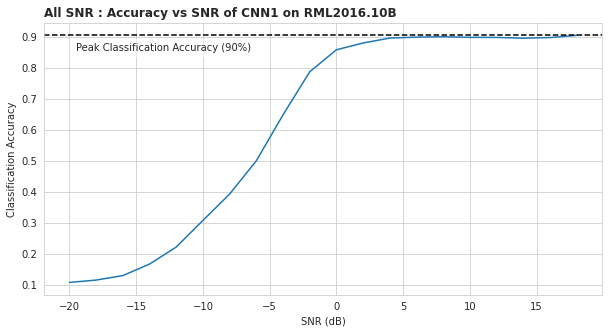

In [ ]:
acc_vs_snr, snr = compute_accuracy_on_cross_sections(model=model_allSNR,
                                                     data=test,
                                                     le=le,
                                                     column="SNR")

title = "All SNR : Accuracy vs SNR of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_acc_vs_snr(acc_vs_snr=acc_vs_snr, snr=snr, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/acc_vs_snr.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### High SNR

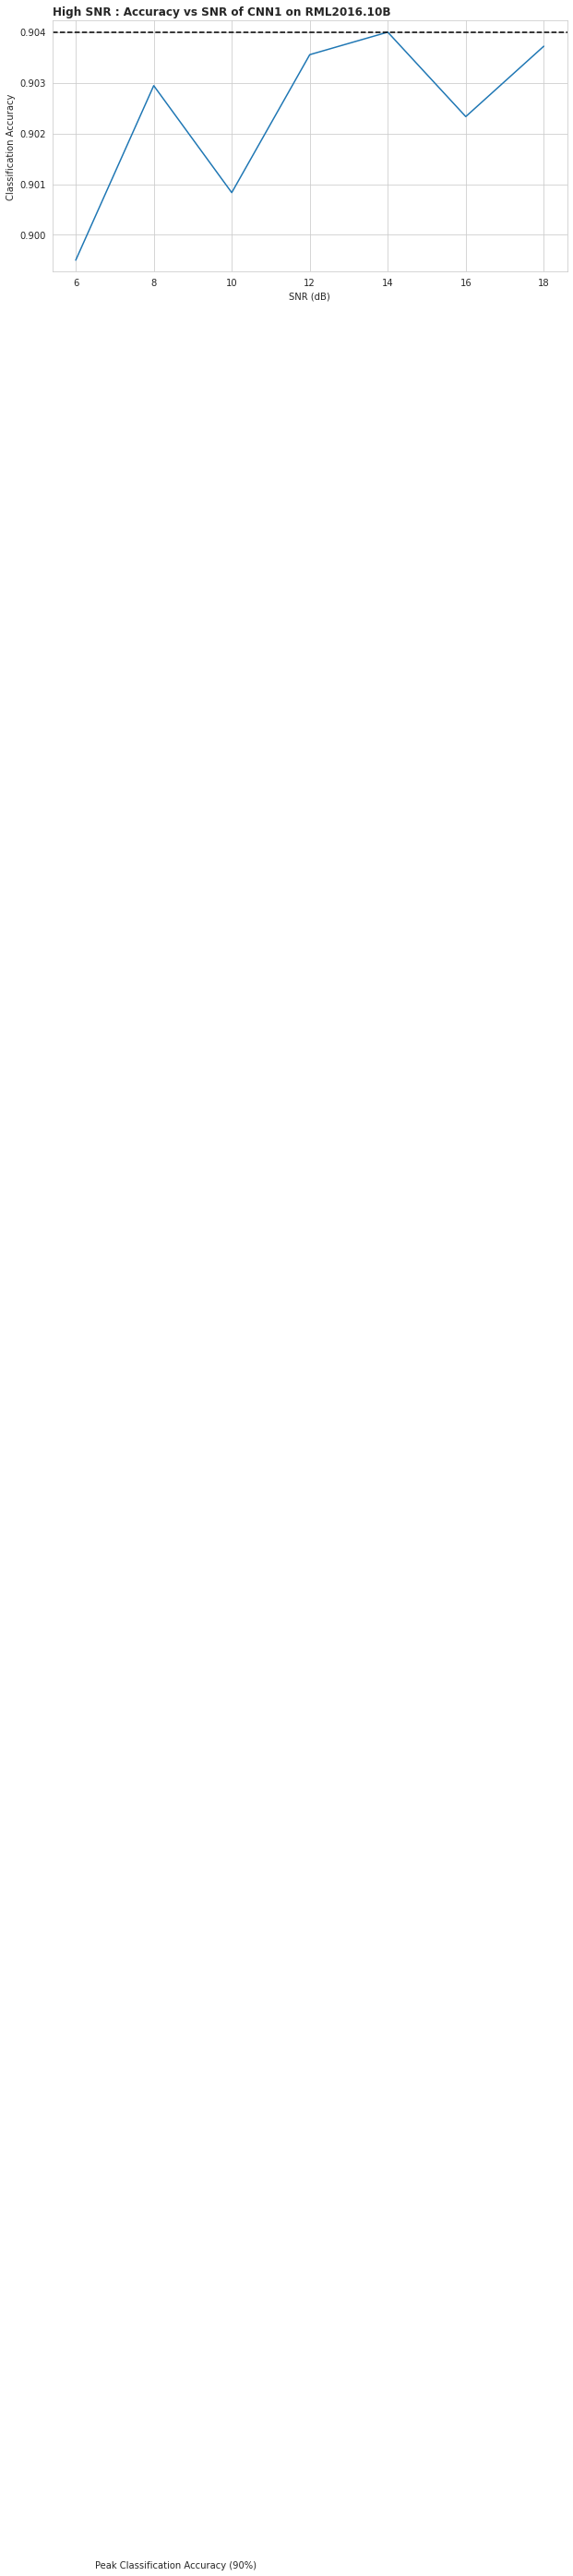

[10, 8, 12, 16, 14, 6, 18]


In [ ]:
acc_vs_snr, snr = compute_accuracy_on_cross_sections(model=model_highSNR,
                                                     data=test_high_snr,
                                                     le=le,
                                                     column="SNR")

title = "High SNR : Accuracy vs SNR of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_acc_vs_snr(acc_vs_snr=acc_vs_snr, snr=snr, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/highSNR_acc_vs_snr.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()


### Medium SNR

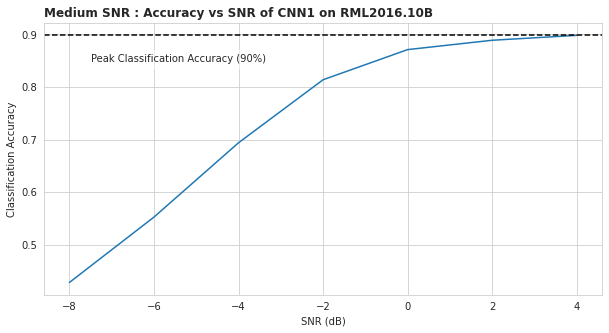

In [ ]:
acc_vs_snr, snr = compute_accuracy_on_cross_sections(model=model_medSNR,
                                                     data=test_med_snr,
                                                     le=le,
                                                     column="SNR")

title = "Medium SNR : Accuracy vs SNR of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_acc_vs_snr(acc_vs_snr=acc_vs_snr, snr=snr, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/medSNR_acc_vs_snr.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### Low SNR

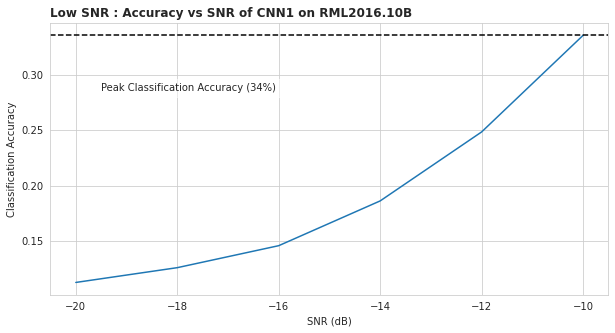

In [ ]:
acc_vs_snr, snr = compute_accuracy_on_cross_sections(model=model_lowSNR,
                                                     data=test_low_snr,
                                                     le=le,
                                                     column="SNR")

title = "Low SNR : Accuracy vs SNR of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_acc_vs_snr(acc_vs_snr=acc_vs_snr, snr=snr, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/lowSNR_acc_vs_snr.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

## Confusion matrix

### All SNR

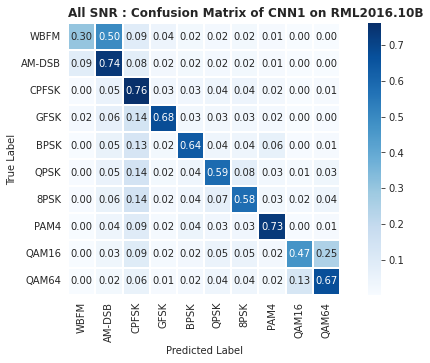

In [ ]:
cmn = compute_confusion(model=model_allSNR, data=test, le=le)

title = "All SNR : Confusion Matrix of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/allSNR_confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### High SNR

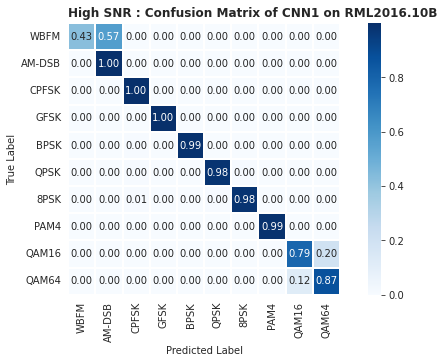

In [ ]:
cmn = compute_confusion(model=model_highSNR, data=test_high_snr, le=le)

title = "High SNR : Confusion Matrix of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/highSNR_confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### Medium SNR

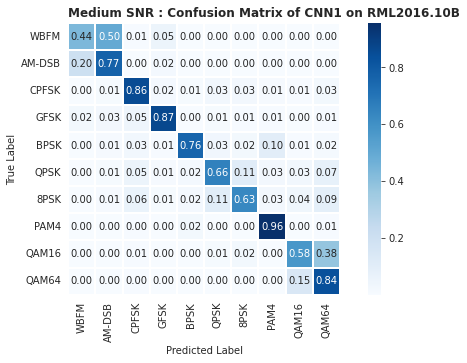

In [ ]:
cmn = compute_confusion(model=model_medSNR, data=test_med_snr, le=le)

title = "Medium SNR : Confusion Matrix of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/medSNR_confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### Low SNR

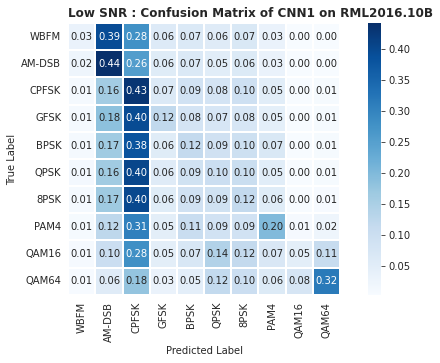

In [ ]:
cmn = compute_confusion(model=model_lowSNR, data=test_low_snr, le=le)

title = "Low SNR : Confusion Matrix of {model_name} on {dataset_name}".format(model_name="CNN1", dataset_name="RML2016.10B")
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/lowSNR_confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

### SEN

[-20,-10]
[-8,4]
[6,18]
[-20,-10]
[-8,4]
[6,18]
[-20,-10]
[-8,4]
[6,18]


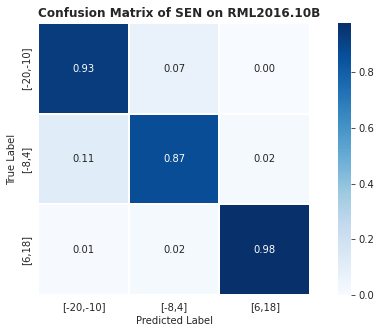

In [ ]:
sen_cmn = compute_confusion(model=sen_model, data=test, le=snr_enc)
title = "Confusion Matrix of {model_name} on {dataset_name}".format(model_name="SEN", dataset_name="RML2016.10B")
fig = plot_confusion(cm=sen_cmn, labels=snr_enc.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/sen_confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)

plt.show()

# Test Cascaded Models

In [148]:
import pandas as pd

def compute_cascaded_sen_amc_accuracy(
    sen_model: Model,
    high_snr_model: Model,
    med_snr_model: Model,
    low_snr_model: Model,
    data: Dataset,
    le: Encoder,
    batch_size: int = 512,
    mask: pd.DataFrame.mask = None,
) -> float:
    """Compute the Top-1 accuracy of this cascading SEN & AMC Models

    Args:
        senModel (senModel): (Trained) SEN model.
        highSNRModel (highSNRModel): (Trained) model to on high SNR.
        medSNRModel (medSNRModel): (Trained) model to on high SNR.
        lowSNRModel (lowSNRModel): (Trained) model to on high SNR.
        data (Dataset): (Testing) data to use for evaluation.
        le (Encoder): Mapping from human readable to machine readable.
        batch_size (int, optional): Defaults to 512.
        mask (pd.DataFrame.mask, optional): Mask to apply to the data before computing
                                            accuracy.  Defaults to None.

    Returns:
        float: Top-1 Accuracy - All SNR
        float: Top-1 Accuracy - High SNR
        float: Top-1 Accuracy - Med SNR
        float: Top-1 Accuracy - Low SNR
        
    """

    dl = DataLoader(
        data.as_torch(le=le, mask=mask), shuffle=True, batch_size=batch_size
    )

    rightLowSNR = 0
    rightMedSNR = 0
    rightHighSNR = 0
    
    nExamplesLowSNR = 0
    nExamplesMedSNR = 0
    nExamplesHighSNR = 0

    for _, data in enumerate(dl):
        inputs, labels = data
        # SNR estimation
        snr_predictions = sen_model.predict(inputs)
        # Divide according to SNR Estimation
        low_snr_indx =  (snr_predictions == 0).nonzero(as_tuple=True)[0]
        med_snr_indx =  (snr_predictions == 1).nonzero(as_tuple=True)[0]
        high_snr_indx = (snr_predictions == 2).nonzero(as_tuple=True)[0]
        
        if(len(low_snr_indx) > 0):
          low_snr_inputs  = inputs[low_snr_indx,  :, :, :]
          low_snr_labels =  labels[low_snr_indx]
          low_snr_pred =  low_snr_model.predict(low_snr_inputs)
          rightLowSNR += (low_snr_pred == low_snr_labels).sum().item()
          nExamplesLowSNR += len(low_snr_labels)

        if(len(med_snr_indx) > 0):  
          med_snr_inputs  = inputs[med_snr_indx,  :, :, :]
          med_snr_labels =  labels[med_snr_indx]
          med_snr_pred =  med_snr_model.predict(med_snr_inputs)
          rightMedSNR += (med_snr_pred == med_snr_labels).sum().item()
          nExamplesMedSNR += len(med_snr_labels)

        if(len(high_snr_indx) > 0):
          high_snr_inputs = inputs[high_snr_indx, :, :, :]
          high_snr_labels = labels[high_snr_indx]
          high_snr_pred = high_snr_model.predict(high_snr_inputs)
          rightHighSNR += (high_snr_pred == high_snr_labels).sum().item()
          nExamplesHighSNR += len(high_snr_labels)
    
    accLow = float(rightLowSNR) / nExamplesLowSNR
    accMed = float(rightMedSNR) / nExamplesMedSNR
    accHigh = float(rightHighSNR) / nExamplesHighSNR
    
    totalRight = rightLowSNR + rightMedSNR + rightHighSNR
    nTotalExamples = nExamplesLowSNR + nExamplesMedSNR + nExamplesHighSNR
    accAll = float(totalRight) / nTotalExamples
    
    return accAll, accHigh, accMed, accLow

In [149]:
accAll, accHigh, accMed, accLow = compute_cascaded_sen_amc_accuracy(sen_model=sen_model, 
                                                                    high_snr_model = model_highSNR,
                                                                    med_snr_model = model_medSNR,
                                                                    low_snr_model = model_lowSNR,
                                                                    data=test, le=le)
print('ACC LOW : ', accLow)
print('ACC MED : ', accMed)
print('ACC HIGH : ', accHigh)
print('ACC ALL : ', accAll)

ACC LOW :  0.18933724584584932
ACC MED :  0.77261965515222
ACC HIGH :  0.9071587386339185
ACC ALL :  0.632965019433648
